In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib.lines import Line2D
import matplotlib.ticker as plticker

In [2]:
wd = "../../"
bench_results = f"{wd}/benchmarks/data/output/dump_chrom/report.tsv"

tool_pretty_names = {
    "cooler_cooler": "cooler",
    "straw_hic": "straw",
    "straw_sorted_hic": "straw (sorted)",
    "hictk_hic": "hictk (hic)",
    "hictk_cooler": "hictk (cooler)",
}

resolutions_pretty = {
    10: "10",
    100: "100",
    500: "500",
    1000: "1k",
    5000: "5k",
    10000: "10k",
    25000: "25k",
    50000: "50k",
    100000: "100k",
    250000: "250k",
    500000: "500k",
    1000000: "1M",
    2500000: "2.5M",
    5000000: "5M",
}

color_palette = ["cornflowerblue", "red", "forestgreen", "darkorange", "darkred"]

matplotlib.rcParams.update(
    {"axes.titlesize": 10, "axes.labelsize": 22, "legend.fontsize": 17, "xtick.labelsize": 18, "ytick.labelsize": 18}
)

In [3]:
def import_data(path) -> pd.DataFrame:
    df = pd.read_table(path)
    df["time_min"] = df["time"] / 60  # sec -> min
    df["memory_gb"] = df["memory"] / 1.0e6  # kb -> gb
    df["tool"] = (df["tool"] + "_" + df["format"]).map(tool_pretty_names)
    df["resolution_pretty"] = df["resolution"].map(resolutions_pretty)

    return df.sort_values("resolution")

In [4]:
df = import_data(bench_results)
df1 = df.groupby(["tool", "resolution"])["time"].median().reset_index()

cooler_runtime = df1.loc[df1["tool"] == "cooler", "time"].to_numpy()
straw_runtime = df1.loc[df1["tool"] == "straw", "time"].to_numpy()
straw_sorted_runtime = df1.loc[df1["tool"] == "straw (sorted)", "time"].to_numpy()
hictk_cooler_runtime = df1.loc[df1["tool"] == "hictk (cooler)", "time"].to_numpy()
hictk_hic_runtime = df1.loc[df1["tool"] == "hictk (hic)", "time"].to_numpy()

df1 = df.groupby(["tool", "resolution"])["memory"].median().reset_index()

cooler_memory = df1.loc[df1["tool"] == "cooler", "memory"].to_numpy()
straw_memory = df1.loc[df1["tool"] == "straw", "memory"].to_numpy()
straw_sorted_memory = df1.loc[df1["tool"] == "straw (sorted)", "memory"].to_numpy()
hictk_cooler_memory = df1.loc[df1["tool"] == "hictk (cooler)", "memory"].to_numpy()
hictk_hic_memory = df1.loc[df1["tool"] == "hictk (hic)", "memory"].to_numpy()

df

,tool,format,resolution,time,memory,time_min,memory_gb,resolution_pretty
0,cooler,cooler,10,619.49,12873736,10.324833,12.873736,10
559,straw,hic,10,164.86,6349068,2.747667,6.349068,10
338,hictk (cooler),cooler,10,113.55,429068,1.892500,0.429068,10
91,hictk (hic),hic,10,120.51,925516,2.008500,0.925516,10
182,straw (sorted),hic,10,194.09,6349776,3.234833,6.349776,10
...,...,...,...,...,...,...,...,...
294,hictk (hic),hic,2500000,0.08,9640,0.001333,0.009640,2.5M
567,straw,hic,2500000,0.10,10088,0.001667,0.010088,2.5M
307,straw,hic,2500000,0.10,10164,0.001667,0.010164,2.5M
138,cooler,cooler,2500000,1.29,89584,0.021500,0.089584,2.5M


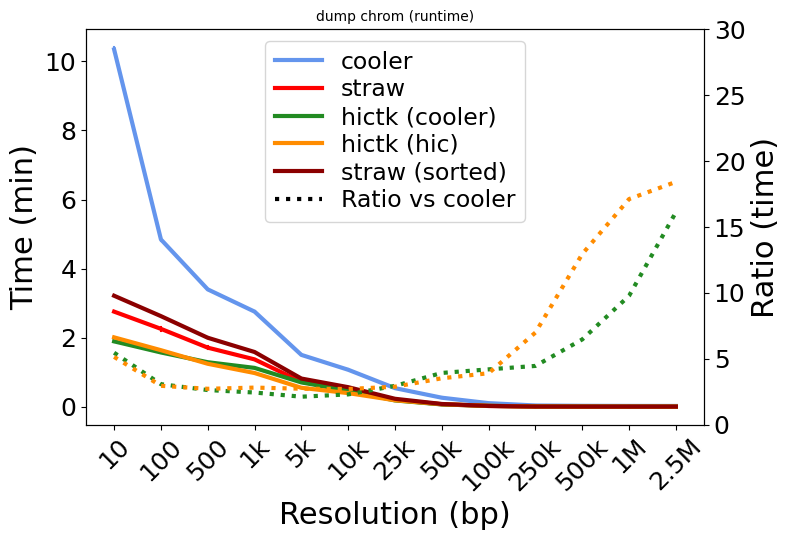

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5.5))
ax2 = ax1.twinx()


sns.lineplot(
    df,
    x="resolution_pretty",
    y="time_min",
    hue="tool",
    palette=color_palette,
    estimator="median",
    err_style="bars",
    errorbar=("se", 2),
    ax=ax1,
    linewidth=3,
    seed=123456,
    legend=True,
)

palette = sns.color_palette()
ax2.plot(
    list(range(df["resolution"].nunique())),
    cooler_runtime / hictk_cooler_runtime,
    linestyle="dotted",
    color=color_palette[2],
    linewidth=3,
)
ax2.plot(
    list(range(df["resolution"].nunique())),
    cooler_runtime / hictk_hic_runtime,
    linestyle="dotted",
    color=color_palette[3],
    linewidth=3,
)

ax1.set(title="dump chrom (runtime)", ylabel="Time (min)", xlabel="Resolution (bp)")

ax1.tick_params(axis="x", rotation=45)
ax2.set(ylabel="Ratio (time)", ylim=(0, 30))

ax1.legend(
    handles=[
        Line2D([0], [0], color=color_palette[0], lw=3, label="cooler"),
        Line2D([0], [0], color=color_palette[1], lw=3, label="straw"),
        Line2D([0], [0], color=color_palette[2], lw=3, label="hictk (cooler)"),
        Line2D([0], [0], color=color_palette[3], lw=3, label="hictk (hic)"),
        Line2D([0], [0], color=color_palette[4], lw=3, label="straw (sorted)"),
        Line2D([0], [0], color="black", linestyle="dotted", lw=3, label="Ratio vs cooler"),
    ],
    labelspacing=0.2,
    loc="upper center",
)

loc1 = plticker.MultipleLocator(base=2)
loc2 = plticker.MultipleLocator(base=5)
ax1.yaxis.set_major_locator(loc1)
ax2.yaxis.set_major_locator(loc2)

fig.tight_layout()
fig.savefig("/tmp/dump_chrom_runtime.png", dpi=600)
fig.savefig("/tmp/dump_chrom_runtime.svg")

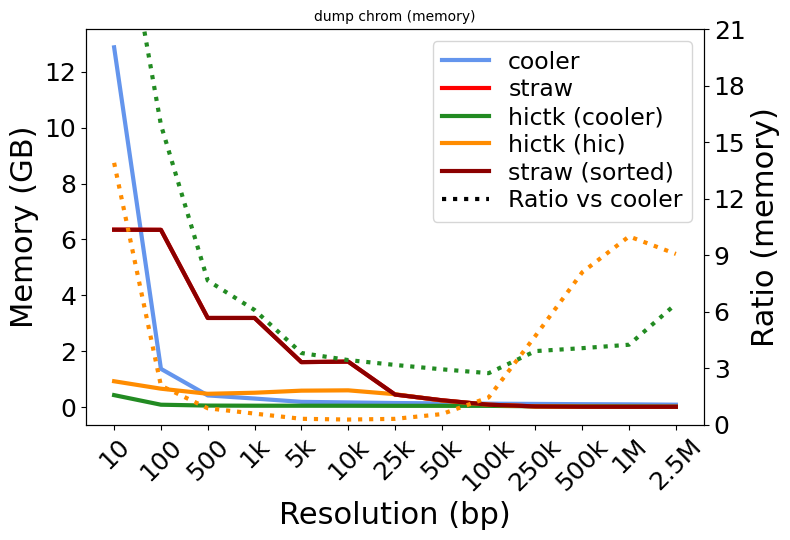

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5.5))
ax2 = ax1.twinx()


sns.lineplot(
    df,
    x="resolution_pretty",
    y="memory_gb",
    hue="tool",
    palette=color_palette,
    estimator="median",
    err_style="bars",
    errorbar=("se", 2),
    ax=ax1,
    linewidth=3,
    seed=123456,
    legend=False,
)

palette = sns.color_palette()
ax2.plot(
    list(range(df["resolution"].nunique())),
    cooler_memory / hictk_cooler_memory,
    linestyle="dotted",
    color=color_palette[2],
    linewidth=3,
)
ax2.plot(
    list(range(df["resolution"].nunique())),
    cooler_memory / hictk_hic_memory,
    linestyle="dotted",
    color=color_palette[3],
    linewidth=3,
)

ax1.set(title="dump chrom (memory)", ylabel="Memory (GB)", xlabel="Resolution (bp)")

ax1.tick_params(axis="x", rotation=45)
ax2.set(ylabel="Ratio (memory)", ylim=(0, 21))

ax1.legend(
    handles=[
        Line2D([0], [0], color=color_palette[0], lw=3, label="cooler"),
        Line2D([0], [0], color=color_palette[1], lw=3, label="straw"),
        Line2D([0], [0], color=color_palette[2], lw=3, label="hictk (cooler)"),
        Line2D([0], [0], color=color_palette[3], lw=3, label="hictk (hic)"),
        Line2D([0], [0], color=color_palette[4], lw=3, label="straw (sorted)"),
        Line2D([0], [0], color="black", linestyle="dotted", lw=3, label="Ratio vs cooler"),
    ],
    labelspacing=0.2,
)

loc1 = plticker.MultipleLocator(base=2)
loc2 = plticker.MultipleLocator(base=3)
ax1.yaxis.set_major_locator(loc1)
ax2.yaxis.set_major_locator(loc2)

fig.tight_layout()
fig.savefig("/tmp/dump_chrom_memory.png", dpi=600)
fig.savefig("/tmp/dump_chrom_memory.svg")